# WeddingWeather
### A pythonic approach of finding nice weather periods during summer in Germany 
In this Python Notebook I try to identify periods of constantly nice weather in Germany in the months of July-September. As my wife and I were setting a date for our wedding, we were wondering if some periods in summer are more stable than others, or if we should avoid certain periods at all. 

These questions were motivated by the occurance of weather anomalies. These are reoccurring periods of good (or bad weather). The most prominent example in Germany is the christmas melting weather around Christmas day which often brings temperatures of about 15°C (and therefore no christmas-like weather).

For this work, we will use data from the German Weather Service (DWD) and the Climate Data Center (CDC) https://www.dwd.de/EN/climate_environment/cdc/cdc.html. We will use data from the meteorological station Clausthal-Zellerfeld, a city in the Harz mountains in central Germany (but any other station can be used).

You can download the data set using 
> `wget https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/daily/kl/historical/tageswerte_KL_00863_18900101_20120331_hist.zip`

In [177]:
%matplotlib inline
import pandas as pd
import copy
from pandas.tseries.offsets import Minute
import matplotlib.pylab as plt
import numpy as np
from datetime import datetime
plt.rcParams['figure.figsize'] = [15.0, 8.0] #[6.0, 4.0]

In [178]:
clz = pd.read_csv("data_clz/produkt_klima_tag_18900101_20120331_00863.txt", sep=';',
                  skipinitialspace=True)

In [179]:
# RSK daily precipitation [mm]
# SDK daily sun-hours [h]
# TMK daily average temperature [°C]
# TXK daily maximum temperature [°C]
# TNK daily minimum temperature [°C]

In [180]:
clz['MESS_DATUM'] = pd.to_datetime(clz['MESS_DATUM'], format='%Y%m%d')
start_date = clz['MESS_DATUM'].iloc[0]
end_date   = clz['MESS_DATUM'].iloc[-1]
print "Data start date: ", start_date
print "Data end date: ", end_date

Data start date:  1890-01-01 00:00:00
Data end date:  2012-03-31 00:00:00


In [181]:
print clz.keys()

Index([u'STATIONS_ID', u'MESS_DATUM', u'QN_3', u'FX', u'FM', u'QN_4', u'RSK',
       u'RSKF', u'SDK', u'SHK_TAG', u'NM', u'VPM', u'PM', u'TMK', u'UPM',
       u'TXK', u'TNK', u'TGK', u'eor'],
      dtype='object')


We will not use the full dataset and limit ourselves to the last 50 years or so.

In [182]:
start_date = '1970-04-01'

## Precipitation data
The first variable to analyze will be the precipitation data (labelled RSK)

In [183]:
# Slice data and create time series
rsk = pd.Series(np.array(clz['RSK']), index = clz['MESS_DATUM'])
rsk_dataset = rsk[start_date:end_date] 
print np.min(rsk_dataset),np.max(rsk_dataset)

-999.0 93.3


We notice that unavailable data sets contain -999. We will set those values to zeros.

In [184]:
rsk_dataset = rsk_dataset.replace(-999.0, 0.0)
print np.min(rsk_dataset), np.max(rsk_dataset)

0.0 93.3


Use pandas dataset functions to calculate mean and standard deviation. We also want to know how big the variability is.

In [185]:
rsk_grouped = rsk_dataset.groupby([rsk_dataset.index.month, rsk_dataset.index.day])
rsk_mean = rsk_grouped.mean()
rsk_std  = rsk_grouped.std()

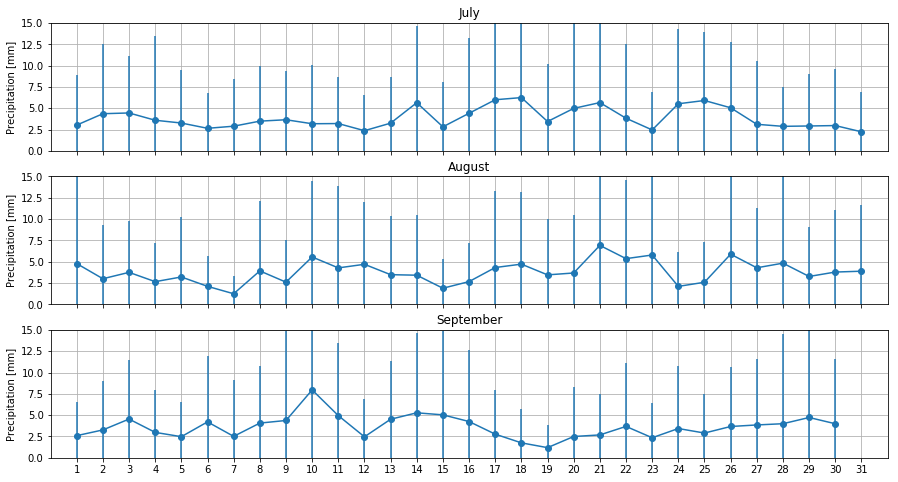

In [186]:
x = np.arange(1,32,1.0)
x30 = np.arange(1,31,1.0)

f, axarr = plt.subplots(3, sharex=True)
axarr[0].errorbar(x,rsk_mean[7], yerr=np.array(rsk_std[7]),fmt='o-')
axarr[0].set_title("July")

axarr[1].errorbar(x,rsk_mean[8], yerr=np.array(rsk_std[8]),fmt='o-')
axarr[1].set_title("August")

axarr[2].errorbar(x30,rsk_mean[9], yerr=np.array(rsk_std[9]),fmt='o-')
axarr[2].set_title("September")

for i in range(3):
    axarr[i].set_ylim([0,15])
    axarr[i].set_xlim([0,32])
    axarr[i].set_xticks(x)
    axarr[i].set_ylabel('Precipitation [mm]')
    axarr[i].grid()

plt.show()

What can we learn from these plots? First of all, we notice that the second half of July is rather wet compared to the beginning of July and August. August, in total, seems rather stable. Apparently, the beginning of August seems very promising with little rain and a small standard deviation.
It is also interesting to note that there is a dry and stable phase around September 19th. I can confirm this anomaly because it is around an annual festival in my hometown which almost always has nice weather.

## Chance of rain
A second variable we are interested in is the chance of rain. Let's define a rainy day by having than 2 mm of precipitation. So we will count all rain days with a 1 and sunny days with 0.

In [187]:
rsk_prob = copy.deepcopy(rsk[start_date:end_date])
rsk_prob[rsk_prob < 2.0] = 0.0
rsk_prob[rsk_prob >= 2.0] = 1.0
print np.min(rsk_prob), np.max(rsk_prob)
rsk_prob_grouped = rsk_prob.groupby([rsk_prob.index.month, rsk_prob.index.day])
rsk_prob_mean = rsk_prob_grouped.mean()

0.0 1.0


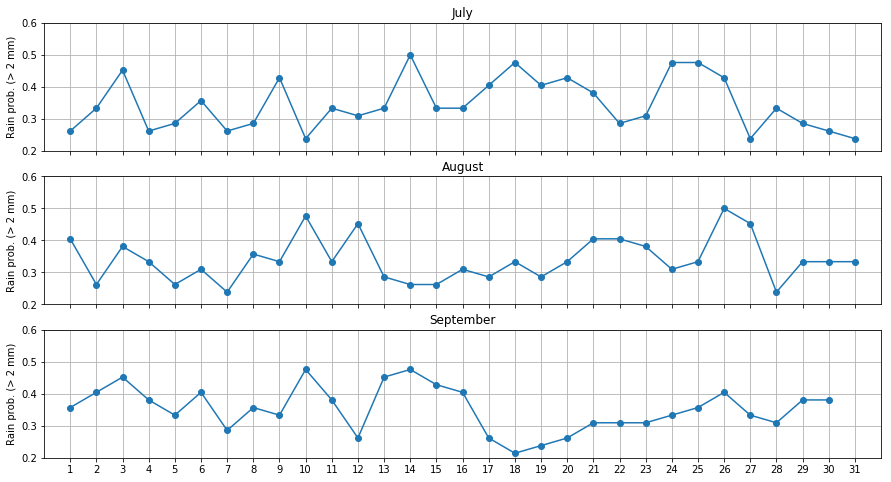

In [188]:
x = np.arange(1,32,1.0)

f, axarr = plt.subplots(3, sharex=True)
axarr[0].plot(x,rsk_prob_mean[7],'o-')
axarr[0].set_title("July")

axarr[1].plot(x,rsk_prob_mean[8],'o-')
axarr[1].set_title("August")

axarr[2].plot(x30,rsk_prob_mean[9],'o-')
axarr[2].set_title("September")

for i in range(3):
    axarr[i].set_ylim([0.2,0.6])
    axarr[i].set_xlim([0,32])
    axarr[i].set_xticks(x)
    axarr[i].set_ylabel('Rain prob. (> 2 mm)')
    axarr[i].grid()

plt.show()

We find again a similar trend, however, not as clear as before. End of July and beginning of August appears to be a quite stable phase with a small chance of rain. There is also again the September dip giving nice and stable weather around the 19th. This diagram seems more helpful by telling which days to avoid instead of which ones to choose.

## Average number of sun hours

As the last variable we will look at the average number of sunshine duration. In this data set, we will replace the missing data points by 4 h of sun on that day. This seems like a reasonable approach.

In [189]:
# Slice data nach Datum und erzeuge Zeitreihe
sdk = pd.Series(np.array(clz['SDK']), index = clz['MESS_DATUM'])
sdk_dataset = sdk[start_date:end_date] 
print np.min(sdk_dataset),np.max(sdk_dataset)

-999.0 15.7


In [190]:
sdk_dataset = sdk_dataset.replace(-999.0, 4.)
print np.min(sdk_dataset), np.max(sdk_dataset)

0.0 15.7


In [191]:
sdk_grouped = sdk_dataset.groupby([sdk_dataset.index.month, sdk_dataset.index.day])
sdk_mean = sdk_grouped.mean()
sdk_std  = sdk_grouped.std()
sdk_max = sdk_grouped.max()
sdk_min = sdk_grouped.min()

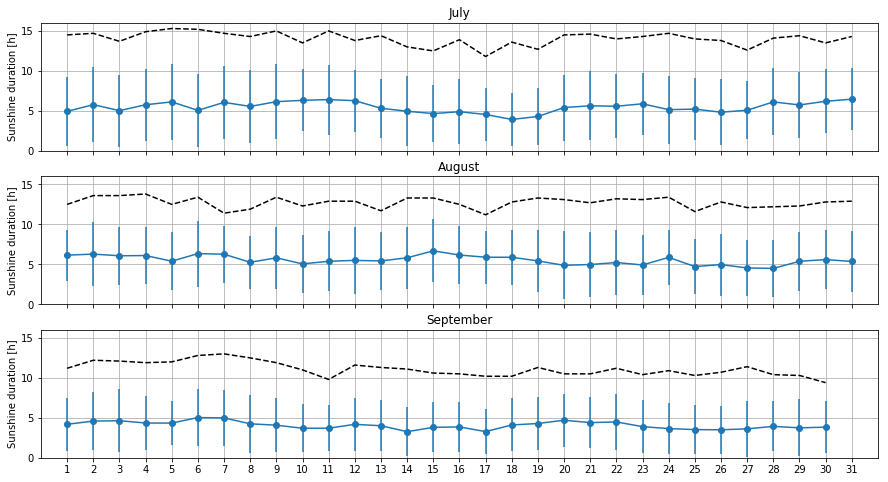

In [192]:
x = np.arange(1,32,1.0)
x30 = np.arange(1,31,1.0)
f, axarr = plt.subplots(3, sharex=True)
axarr[0].errorbar(x,sdk_mean[7], yerr=np.array(sdk_std[7]),fmt='o-')
axarr[0].plot(x,sdk_max[7],'k--')
axarr[0].set_title("July")

axarr[1].errorbar(x,sdk_mean[8], yerr=np.array(sdk_std[8]),fmt='o-')
axarr[1].plot(x,sdk_max[8],'k--')
axarr[1].set_title("August")

axarr[2].errorbar(x30, sdk_mean[9], yerr=np.array(sdk_std[9]),fmt='o-')
axarr[2].set_title("September")
axarr[2].plot(x30,sdk_max[9],'k--')

for i in range(3):
    axarr[i].set_ylim([0,16])
    axarr[i].set_xlim([0,32])
    axarr[i].set_xticks(x)
    axarr[i].set_ylabel('Sunshine duration [h]')
    axarr[i].grid()
plt.show()

This graph is somewhat unconclusive as there is often a big difference between the maximum and the actual mean sunshine duration per day. It is probably more useful to calculate and plot the difference between the daily sunshine duration and the maximum possible duration for that day and location. 

However, we see again that late July and early August are quite stable. It is also very interesting to look at the maximum number of sunshine for that day as there are considerable dips. This could indicate periods of better (or worse) weather.

## Summary
Even though it is difficult to interpret these graphs properly and considering there is much more data to look at, we can draw some general conclusions about the summer weather in Clausthal-Zellerfeld.
1. The first halfs of July and August appear quite stable.
2. Avoid the second half of July. 
3. The second half of August is quite unpredictable. 
4. There is a significant period of nice weather around September 19th. 